<a href="https://colab.research.google.com/github/juacardonahe/Curso_NLP/blob/main/1_FundamentosNLP/1.1_Introducci%C3%B3nNLP/1_1_6_NLP_SpamAplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/UNAL_Field_w.png" width="40%">

# **Procesamiento de Lenguaje Natural (NLP)**
### Departamento de Ingeniería Eléctrica, Electrónica y Computación
#### Universidad Nacional de Colombia - Sede Manizales

#### Elaboró: Juan José Cardona H.
#### Revisó: Diego A. Perez

# **Introducción al Procesamiento de Lenguaje Natural**

En este notebook, exploraremos las dificultades y particularidades al trabajar con datos de texto. Como tarea de ejemplo, utilizaremos la colección SMS Spam. Esta contiene aproximadamente 5600 mensajes que han sido clasificados manualmente en dos categorías: "spam" (correo no deseado) y "ham" (no spam o mensajes legítimos).

*Advertencia: Algunos de los mensajes de texto pueden contener palabras ofensivas o contenido sexual.*

## Carga de datos

Comencemos cargando los datos y echémosle un primer vistazo.


In [ ]:
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"

In [ ]:
import pandas as pd
import urllib.request
data = urllib.request.urlopen(url)

lines_split = [
    line.decode().strip().split("\t")
    for line in data
]
df = pd.DataFrame(lines_split, columns=["label", "text"])

Miremos 5 mensajes aleatorios de nuestros datos.

In [ ]:
df.sample(5, random_state=123)

,label,text
3237,ham,Aight text me when you're back at mu and I'll ...
843,ham,Our Prashanthettan's mother passed away last n...
3521,ham,No it will reach by 9 only. She telling she wi...
2123,ham,Do you know when the result.
738,spam,Hi. Customer Loyalty Offer:The NEW Nokia6650 M...


Dado que estamos trabajando con mensajes de texto, nuestros datos están bastante desordenados.

¿Cuál es la proporción de mensajes "ham" (no spam) frente a los mensajes "spam"?


In [ ]:
df["label"].value_counts()

,count
label,
ham,4827
spam,747


## **Extracción de características del texto**

No podemos alimentar datos de texto directamente a un modelo; necesitamos valores numéricos en su lugar. En nuestro primer modelo, no analizaremos el contenido de las palabras, sino que nos centraremos en otras características que podemos extraer del texto. En particular, calcularemos:

- La longitud de un mensaje de texto.
- El número de signos de puntuación utilizados.
- El número de letras en mayúsculas.
- El número de números.
- El número de ocurrencias de la letra X.


In [ ]:
simple_features = df.copy()

simple_features["length"] = df["text"].apply(len)
simple_features["number_punctuation"] = df["text"].apply(lambda x: sum(1 for letter in x if letter in '".,;:!?()_*'))
simple_features["number_uppercase"] = df["text"].apply(lambda x: sum(1 for letter in x if letter!=letter.lower()))
simple_features["number_numbers"] = df["text"].apply(lambda x: sum(1 for letter in x if letter in "0123456789"))
simple_features["number_x"] = df["text"].apply(lambda x: sum(1 for letter in x if letter in "xX"))

simple_features["is_spam"] = df["label"] == "spam"

Vamos a visualizar el efecto de nuestras nuevas características mediante diagramas de caja (box-plots).


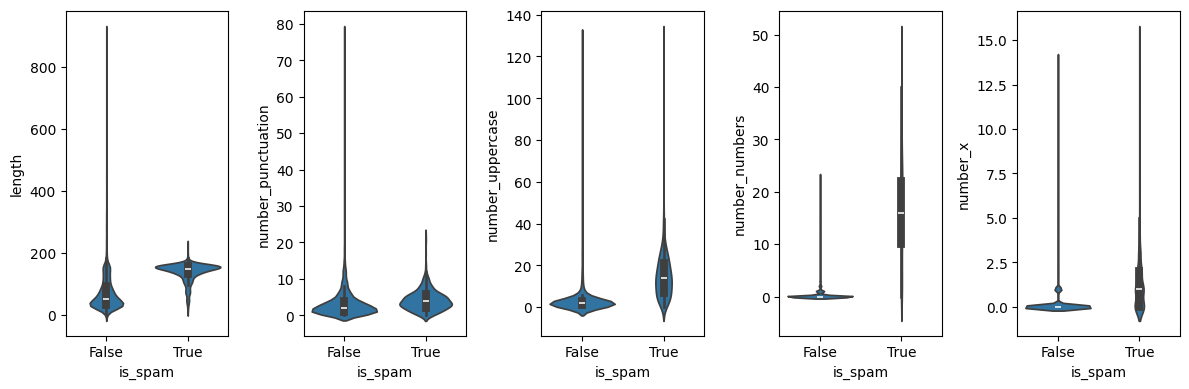

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(12, 4))
sns.violinplot(simple_features, x="is_spam", y="length", ax=axs[0])
sns.violinplot(simple_features, x="is_spam", y="number_punctuation", ax=axs[1])
sns.violinplot(simple_features, x="is_spam", y="number_uppercase", ax=axs[2])
sns.violinplot(simple_features, x="is_spam", y="number_numbers", ax=axs[3])
sns.violinplot(simple_features, x="is_spam", y="number_x", ax=axs[4])

fig.tight_layout()

¿Qué tan bien nos desempeñamos con un modelo logístico simple?


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

train, test = train_test_split(simple_features, test_size=.2, random_state=123)

features = [
    "length",
    "number_punctuation",
    "number_uppercase",
    "number_numbers",
    "number_x",
]

logistic_regression = LogisticRegression()
logistic_regression.fit(train[features], train["is_spam"])

test_predictions = logistic_regression.predict(test[features])

Vamos a calcular la precisión (precision) y la exhaustividad (recall):


In [ ]:
print("Precision:", precision_score(test["is_spam"], test_predictions))
print("Recall:", recall_score(test["is_spam"], test_predictions))

Precision: 0.9448275862068966
Recall: 0.8616352201257862


Vemos que ya obtenemos un rendimiento muy bueno sin siquiera observar las palabras en los datos.

## **Conversión del texto a valores numéricos**
A continuación, queremos crear modelos que realmente analicen el contenido de nuestros mensajes. Para ello, necesitamos convertir el contenido de los mensajes en una representación numérica, que luego podremos pasar a un modelo.

Veamos un solo mensaje de texto:


In [ ]:
example_text = df.loc[4233, "text"]
example_text

"I'm at home. Please call"

¿Cómo podríamos hacer eso? Dado que nuestro lenguaje está compuesto por palabras, parece intuitivo dividir nuestros mensajes en palabras. Luego, podemos asignar un número único a cada palabra. Dividir un documento de texto en partes más pequeñas (típicamente palabras o partes de palabras) se llama tokenization.

Para dividir nuestros mensajes en palabras, primero eliminamos toda la puntuación, excepto la coma, y luego dividimos en cada espacio en blanco.

In [ ]:
def remove_punctuation(text):
    for letter in '".,;:!?()_*':
        text = text.replace(letter, " ")  # replace with a space
    return text

def to_word_list(text):
    without_punctuation = remove_punctuation(text)
    return without_punctuation.split()  # splits at any whitespace

word_list = to_word_list(example_text)
word_list

["I'm", 'at', 'home', 'Please', 'call']

Ahora le damos un ID unico a cada palabra:

In [ ]:
def get_word_dictionary(word_list):
    """Create a mapping from every word to an integer."""
    return {
        word: i
        for i, word in enumerate(set(word_list))
    }


word_dict = get_word_dictionary(word_list)
number_list = [word_dict[word] for word in word_list]

# let's look at the word dictionary
word_dict

{'home': 0, 'Please': 1, 'call': 2, 'at': 3, "I'm": 4}

El texto ahora está codificado como la siguiente lista de números:

In [ ]:
number_list

[4, 3, 0, 1, 2]

Ahora hemos obtenido una primera representación numérica de nuestros datos de muestra. Sin embargo, pasarla tal como está a algún modelo no tiene mucho sentido: El orden de las palabras se elige arbitrariamente, por lo que los números no significan realmente nada. Este es un problema: El modelo considerará que los números más cercanos entre sí son más similares que los números que están más alejados.

Para hacer que cada palabra esté igualmente separada, podemos convertir nuestra oración en una llamada one-hot encoding. Mapeamos cada palabra a un vector, donde el tamaño del vector es igual al número de palabras en el corpus. Este vector tiene valor cero en todas partes, excepto en una fila: Colocamos el valor 1 en la fila correspondiente al número que se le asignó a nuestra palabra.

Por ejemplo: Si tenemos un total de 5 palabras, crearíamos los siguientes vectores:

- Word 0: `[1, 0, 0, 0, 0]`
- Word 1: `[0, 1, 0, 0, 0]`
- Word 2: `[0, 0, 1, 0, 0]`
- Word 3: `[0, 0, 0, 1, 0]`
- Word 4: `[0, 0, 0, 0, 1]`

Vamos a implementarlo en Python:


In [ ]:
def number_to_one_hot(number, vocabulary_size):
    """Function that takes a single integer and the vocabulary size, and creates a one-hot vector."""
    output = [0] * vocabulary_size

    # negative numbers will be reserved for when we encounter a new word
    if number >= 0:
        output[number] = 1
    return output

number_to_one_hot(2, 5)

[0, 0, 1, 0, 0]

In [ ]:
# now we can encode the entire sentence
def number_list_to_one_hot(number_list, vocabulary_size):
    return [
        number_to_one_hot(number, vocabulary_size)
        for number in number_list
    ]

vocabulary_size = max(number_list) + 1

sentence_one_hot = number_list_to_one_hot(number_list, vocabulary_size)
sentence_one_hot

[[0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0]]

Ahora hemos convertido nuestro texto en una representación numérica, donde la distancia entre cada palabra es igual.

## **Codificando todos los mensajes de texto**

Por supuesto, no queremos codificar solo un mensaje, sino todos los mensajes de texto a la vez. Podemos hacer esto de la siguiente manera:

In [ ]:
df["word_lists"] = df["text"].apply(to_word_list)

def flatten_list_of_lists(list_of_lists):
    """Flattens the list of lists [[a], [b, c]] to [a, b, c]."""
    return [
        e
        for sublist in list_of_lists
        for e in sublist
    ]

# create a list of all words
list_of_all_words = flatten_list_of_lists(df["word_lists"].to_list())

# create the dictionary
full_dict = get_word_dictionary(list_of_all_words)

¿Que tan grande es nuestro diccionario?

In [ ]:
len(full_dict)

11479

Hemos encontrado más de 11000 palabras diferentes solo en nuestros 5600 mensajes. Veamos algunas de las palabras que hemos encontrado:

In [ ]:
(
    pd.DataFrame(full_dict.items(), columns=["word", "index"])
    .sort_values("word")
    .sample(10, random_state=1)
)

,word,index
45,jeevithathile,45
9930,wil,9930
661,HATES,661
4641,compare,4641
7218,moon,7218
11265,mush,11265
3837,feb-april,3837
3448,slept,3448
5886,behalf,5886
10383,Gokila,10383


¿Qué observamos?
- Algunas palabras son nombres propios.
- Algunas palabras no son realmente palabras, sino solo onomatopeyas.
- Algunas palabras son variaciones gramaticales de una raíz de palabra.
- Algunas palabras son errores ortográficos.
- Algunas palabras están en mayúsculas.
- Algunas palabras están en otro idioma.

¿Cómo podríamos mejorar esto?

1. Podríamos eliminar palabras que son raras. Esto eliminaría palabras mal escritas, pero también nombres y lugares raros.
2. Podríamos convertir cada palabra a su origen gramatical (por ejemplo: eliminar el plural o conjugar a la raíz de la palabra). Esto se llama "stemming". Reduciríamos drásticamente el tamaño del vocabulario, pero también perderíamos información importante (si es plural o no, etc.).
3. Podríamos convertir cada palabra a minúsculas, ya que las mayúsculas y minúsculas no cambian el significado de la palabra en inglés.

O, alternativamente:

4. Podríamos dividir palabras raras y conjugadas aún más: por ejemplo, dividir "killing" en [kill, #ing], donde # es un carácter especial para denotar que dividimos una palabra. Esto es más complejo de manejar, pero aún puede manejar palabras raras y conjugación. Este último enfoque es lo que normalmente se hace en los modelos de lenguaje grandes modernos. Puedes encontrar una demostración en este enlace: https://codesandbox.io/s/gpt-tokenizer-tjcjoz.


## **Stemming y eliminación de palabras extrañas**

Vamos a implementar los primeros tres puntos mencionados anteriormente. Realizaremos un stemming rudimentario eliminando ciertos sufijos y solo mantendremos las palabras que ocurren más de 10 veces.

In [ ]:
def to_lower_case(word_list):
    return [
        word.lower() for word in word_list
    ]

to_lower_case(df.loc[4233, "word_lists"])


["i'm", 'at', 'home', 'please', 'call']

In [ ]:
def rudimentary_stemming(word_list):
    suffixes_to_remove = [
        "s",  # plural suffix
        "ing",
        "ed",
    ]
    def remove_suffixes(word):
        for suffix in suffixes_to_remove:
            word = word.removesuffix(suffix)
        return word

    return [
        remove_suffixes(word)
        for word in word_list
    ]

to_show_index = 20

print("Original Sentence:  ", df.loc[to_show_index, "text"])
print("Stemmed Version:    ", rudimentary_stemming(df.loc[20, "word_lists"]))


Original Sentence:   Is that seriously how you spell his name?
Stemmed Version:     ['I', 'that', 'seriously', 'how', 'you', 'spell', 'hi', 'name']


Podemos ver que nuestro **stemming** rudimentario tiene muchos fallos. Existen algoritmos más sofisticados en la práctica, como el [Porter Stemming Algorithm](https://de.wikipedia.org/wiki/Porter-Stemmer-Algorithmus).

Ahora podemos crear una nueva columna con las listas de palabras limpiadas.


In [ ]:
df["cleaned_word_lists"] = df["word_lists"].apply(
    lambda x: rudimentary_stemming(to_lower_case(x))
)

Construimos nuestro diccionario a continuación, ahora con el criterio de que cada palabra debe aparecer al menos 10 veces.

In [ ]:
def get_frequent_word_dictionary(word_list, minimum_count=10):
    """Create a mapping from frequent words to an integer."""
    # create a dictionary with the number of occurrences of every word
    word_count = pd.Series(word_list).value_counts().to_dict()

    # identify the set of words that are frequent enough
    relevant_words = {
        word for word, count in word_count.items() if count >= minimum_count
    }

    # turn that set into a dictionary
    return {
        word: i
        for i, word in enumerate(relevant_words)
    }


# create a list of all clean words
list_of_clean_words = flatten_list_of_lists(df["cleaned_word_lists"].to_list())

# create the dictionary
frequent_dict = get_frequent_word_dictionary(list_of_clean_words)

¿Cuantas palabras diferentes tenemos ahora?

In [ ]:
len(frequent_dict)

1045

Esto parece más certero para un corpus de texto con 5600 mensajes de texto.

Luego aplicamos el one-hot encoder a todos nuestros mensajes de texto.

In [ ]:
import numpy as np

df["word_number_list"] = df["cleaned_word_lists"].apply(
    lambda word_list: [
        frequent_dict.get(word, -1)
        for word in word_list
    ]
)

df["one_hot_word_encoding"] = df["word_number_list"].apply(
    lambda number_list: np.array(
        number_list_to_one_hot(number_list, vocabulary_size=len(frequent_dict) + 1)
    )
)

Veamos un ejemplo:

In [ ]:
ix = 0
print("One-Hot Encoding:\n", df["one_hot_word_encoding"][ix])
print("Shape:", df["one_hot_word_encoding"][ix].shape)

One-Hot Encoding:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (20, 1046)


El one-hot encoding tiene una forma igual al número de palabras multiplicado por el tamaño total del diccionario.

Veamos otro ejemplo:

In [ ]:
ix = 1
print("One-Hot Encoding:\n", df["one_hot_word_encoding"][ix])
print("Shape:", df["one_hot_word_encoding"][ix].shape)

One-Hot Encoding:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape: (6, 1046)


Dado que este segundo mensaje de texto fue más corto, el **encoding** resultante también fue más corto.

Este es un problema: los modelos estándar, como las regresiones lineales y tambien las redes neuronales feed-forward, quieren que nuestra entrada siempre tenga el mismo tamaño. ¿Cómo podemos manejar las diferentes longitudes de nuestras entradas?

## **Bag of Words (BoW)**
La forma más fácil de manejar longitudes de entrada variables es calcular la suma de los one-hot encodings de cada palabra. Conceptualmente, esto solo calcula cuántas veces ocurre una palabra en el texto. Por esta razón, este método se llama bag of words.

Por ejemplo: El bag of words encoding de la oración "hello, how are you and how are your parents?" es:

|I|you|hello|how|are|parents|your|and|
|-|---|-----|---|---|-------|----|---|
|0|1  |1    |2  |2  |1      |1   |1  |

Calculemos el BoW para todos nuestros datos:

In [ ]:
df["bag_of_words"] = df["one_hot_word_encoding"].apply(lambda x: np.sum(x, axis=0))

df["bag_of_words"]

,bag_of_words
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
5569,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5570,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5572,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Esto lo podemos usar ahora para entrenar nuestro modelo:

In [ ]:
bag_of_words_df = df["bag_of_words"].apply(pd.Series)
target = df["label"] == "spam"

# we have to use the same test_size and random state as above to ensure comparability
train_x, test_x, train_y, test_y = train_test_split(
    bag_of_words_df, target, test_size=.2, random_state=123
)

# let's look at our training data
train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045
385,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1283,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Entrenemos un modelo linear con esto:

In [ ]:
bow_model = LogisticRegression()
bow_model.fit(train_x.fillna(0), train_y)

bow_predictions = bow_model.predict(test_x.fillna(0))

In [ ]:
print("Precision:", precision_score(test["is_spam"], bow_predictions))
print("Recall:", recall_score(test["is_spam"], bow_predictions))

Precision: 0.9867549668874173
Recall: 0.9371069182389937


Vemos que, al analizar nuestro contenido, podríamos mejorar significativamente el rendimiento de nuestro modelo.

## **¿Qué se podria considerar para mejorar?**
Nuestro modelo de **bag of words** tiene margen de mejora:
- Nuestros vectores son muy dispersos y no contienen mucha información.
- No tenemos en cuenta el orden de las palabras.
- No distinguimos entre palabras en minúsculas y mayúsculas, puntuación, etc.

